## Plot train/test error across different models/n train frames

In [1]:
import hydra
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torch
from omegaconf import DictConfig

from lightning_pose.utils.io import return_absolute_data_paths
# from lightning_pose.utils.pca import KeypointPCA, compute_pca_reprojection_error
# from lightning_pose.utils.predictions import predict_dataset
from lightning_pose.utils.scripts import (
    get_imgaug_transform, get_dataset, get_data_module, get_loss_factories,
)

import sys
#sys.path.append('/home/mattw/Dropbox/github/paninski-lab/tracking-diagnostics')
sys.path.append('/home/jovyan/tracking-diagnostics')

from diagnostics.handler import ModelHandler
from diagnostics.io import get_keypoint_names, get_base_config, update_loss_config
from diagnostics.visualizations import get_y_label

/home/jovyan/conda/lib/python3.8/site-packages/typeguard/__init__.py:1016: UserWarning: no type annotations present -- not typechecking lightning_pose.models.base.grab_layers_sequential_3d
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))


### define configuration

In [2]:
# dataset_name = "ibl-fingers"
# dataset_name = "ibl-pupil-2"
# dataset_name = "ibl-pupil-ks004-2"
# dataset_name = "fly-2"
# dataset_name = "ibl-paw-2"
dataset_name = "mirror-mouse"
# dataset_name = "mirror-mouse-1.5"
# dataset_name = "mirror-fish"
# dataset_name = "fly"
# dataset_name = 'ibl-paw-2view-1'
# dataset_name = 'ibl-pupil-2'

base_config_dir = "/home/jovyan/configs-mirror-mouse"#"/home/mattw/Dropbox/research-code/pose-estimation/configs"
base_save_dir = "/home/jovyan/lightning-pose"

model_name = "singleview_sweep" #'grid-search-0'

cfg = get_base_config(base_config_dir, "config_%s" % dataset_name)

/home/jovyan/tracking-diagnostics/diagnostics/io.py:244: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize_config_dir(config_dir)


In [3]:
# load ground truth labels
csv_file = os.path.join(cfg.data.data_dir, cfg.data.csv_file)
csv_data = pd.read_csv(csv_file, header=list(cfg.data.header_rows), index_col=0)
keypoints_gt = csv_data.to_numpy().reshape(csv_data.shape[0], -1, 2)
keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)

In [4]:
cfg.data.data_dir

'/datastores/mirror-mouse'

In [17]:
save_dir = base_save_dir # os.path.join(base_save_dir, dataset_name)

# define models
to_compute = "rmse"  # rmse | pca_multiview | pca_singleview | unimodal_mse
train_frame = 125 # 000
rng_seeds = [0, 1, 2]
model_type = "heatmap"
use_held_out_data = False

loss_weight_dict = {
    'supervised': [None],
#     'unimodal_mse': [0.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
#     'unimodal_kl': [2.0, 4.0, 6.0, 8.0, 10.0],
#     'temporal': [4.0, 6.0, 8.0, 10.0],
    'pca_singleview': [3,4,4.5,5,5.5,6,6.5],
#     'pca_multiview': [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
}
do_context = False # TODO: check this arg
pca_obj = None
pca_loss = None
datamodule = None

if to_compute == 'rmse':
    pass
elif to_compute == 'pca_reproj':
    from lightning_pose.utils.pca import KeypointPCA
    data_dir, video_dir = return_absolute_data_paths(data_cfg=cfg.data)
    imgaug_transform = get_imgaug_transform(cfg=cfg)
    dataset = get_dataset(cfg=cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)
    data_module = get_data_module(cfg=cfg, dataset=dataset, video_dir=video_dir)
    data_module.setup()
    # compute pca params
    model_cfg = cfg.copy()
    model_cfg.training.train_frames = train_frame
    model_cfg.model.do_context = do_context
    model_cfg.model.losses_to_use = ["pca_multiview"]
    loss_factories = get_loss_factories(cfg=model_cfg, data_module=data_module)
    pca_loss = loss_factories["unsupervised"].loss_instance_dict[loss_type]
    
#     pca_obj = KeypointPCA(loss_type='pca_singleview', data_module=datamodule)
#     pca_obj()
elif to_compute == 'unimodal_mse' or to_compute == "unimodal_kl":
    pass
elif to_compute == 'temporal_norm':
    raise NotImplementedError
    
if use_held_out_data:
    cfg_new = cfg.copy()
    cfg_new.data.csv_file = cfg.data.csv_file.replace(".csv", "_new.csv")
    cfg_new.training.train_prob = 0.8
    cfg_new.training.val_prob = 0.1
    cfg_new.training.train_frames = train_frame
    imgaug_transform = get_imgaug_transform(cfg=cfg)
    dataset_new = get_dataset(cfg=cfg_new, data_dir=cfg.data.data_dir, imgaug_transform=imgaug_transform)
    datamodule_new = get_data_module(cfg=cfg_new, dataset=dataset_new, video_dir=None)
    datamodule_new.setup()
    # load ground truth labels
    csv_file = os.path.join(cfg_new.data.data_dir, cfg_new.data.csv_file)
    csv_data = pd.read_csv(csv_file, header=list(cfg_new.data.header_rows), index_col=0)
    keypoints_gt = csv_data.to_numpy().reshape(csv_data.shape[0], -1, 2)
else:
    datamodule_new = None
    
# store results here
metrics_collected = {bp: [] for bp in keypoint_names}
cols_collected = []

# loop over models and compute metric of interest
results_df = []
for rng_seed in rng_seeds:
    for loss_type, loss_weights in loss_weight_dict.items():
        for loss_weight in loss_weights:

            # find model checkpoint
            model_cfg = cfg.copy()
            model_cfg.model.do_context = do_context
            model_cfg.training.train_frames = train_frame
            model_cfg.training.rng_seed_data_pt = rng_seed
            model_cfg.training.rng_seed_model_pt = 0 # rng_seed
            model_cfg.model.model_name = model_name

            # put model-specific config info here
            if loss_type == 'supervised':
                model_cfg.model.losses_to_use = []    
            else:
                model_cfg = update_loss_config(model_cfg, loss_type, loss_weight)

            try:
                handler = ModelHandler(
                    save_dir, model_cfg, verbose=False, 
                    keys_to_sweep=['limit_train_batches', 'train_batch_size'])
                print(handler.model_dir)
            except FileNotFoundError:
                print('did not find %s model for train_frames=%i' % (loss_type, train_frame))
                continue

            try:
                if use_held_out_data:
                    pred_filename = 'predictions_held-out.csv'
                else:
                    pred_filename = 'predictions.csv'
                result, conf = handler.compute_metric(
                    to_compute, pred_filename,
                    keypoints_true=keypoints_gt, pca_loss_obj=pca_loss, 
                    datamodule=datamodule_new)
            except FileNotFoundError:
                print('could not find model predictions')
                continue

            if loss_type == 'supervised':
                for loss_type_, loss_weights_ in loss_weight_dict.items():
                    if loss_type_ == 'supervised':
                        # make a supervised entry, but not under this name
                        continue
                    else:
                        cols_collected.append('%s_s' % loss_type_)
                        for b, bodypart in enumerate(keypoint_names):
                            metrics_collected[bodypart].append(result[:, b])
            else:
                cols_collected.append('%s_%.1f' % (loss_type, loss_weight))
                for b, bodypart in enumerate(keypoint_names):
                    metrics_collected[bodypart].append(result[:, b])

    # collect results                
    for bodypart in keypoint_names:
        dict_tmp = {
            'bodypart': bodypart,
            'rng_seed': rng_seed,
            'eval_mode': handler.pred_df.iloc[:, -1].to_numpy(),
            'img_file': csv_data.index,
        }
        for col_name, metric in zip(cols_collected, metrics_collected[bodypart]):
            dict_tmp[col_name] = metric
        results_df.append(pd.DataFrame(dict_tmp))

results_df = pd.concat(results_df)

Found model at: /home/jovyan/lightning-pose/multirun/2022-07-12/14-20-13/0
/home/jovyan/lightning-pose/multirun/2022-07-12/14-20-13/0
Metric: rmse
Found model at: /home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/0
/home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/0
Metric: rmse
Found model at: /home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/1
/home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/1
Metric: rmse
Found model at: /home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/2
/home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/2
Metric: rmse
Found model at: /home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/3
/home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/3
Metric: rmse
Found model at: /home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/4
/home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/4
Metric: rmse
Found model at: /home/jovyan/lightning-pose/multirun/2022-07-12/02-40-34/5
/home/jovyan/lightning-pose/multirun/2022-0

### barplots across all models

In [18]:
df_tmp = pd.melt(
    results_df, 
    id_vars=['bodypart', 'img_file', 'eval_mode', 'rng_seed'], 
    value_vars=cols_collected
)
def add_loss_name_col(row):
    return '_'.join(row['variable'].split('_')[:-1])
def add_loss_val_col(row):
    return row['variable'].split('_')[-1]
df_tmp['loss'] = df_tmp.apply(add_loss_name_col, axis=1)
df_tmp['loss_weight'] = df_tmp.apply(add_loss_val_col, axis=1)

# take mean over keypoints, so that error bars are over rng seeds
df_tmp = df_tmp.groupby(['rng_seed', 'eval_mode', 'loss', 'loss_weight']).mean().reset_index()

In [19]:
df_tmp

,rng_seed,eval_mode,loss,loss_weight,value
0,0,test,pca_singleview,3.0,88.642890
1,0,test,pca_singleview,4.0,6.892569
2,0,test,pca_singleview,4.5,7.866469
3,0,test,pca_singleview,5.0,8.859162
4,0,test,pca_singleview,5.5,9.305947
...,...,...,...,...,...
91,2,validation,pca_singleview,5.0,8.595190
92,2,validation,pca_singleview,5.5,8.112102
93,2,validation,pca_singleview,6.0,10.321153
94,2,validation,pca_singleview,6.5,9.275563


In [20]:
df_tmp.loss_weight

0     3.0
1     4.0
2     4.5
3     5.0
4     5.5
     ... 
91    5.0
92    5.5
93    6.0
94    6.5
95      s
Name: loss_weight, Length: 96, dtype: object

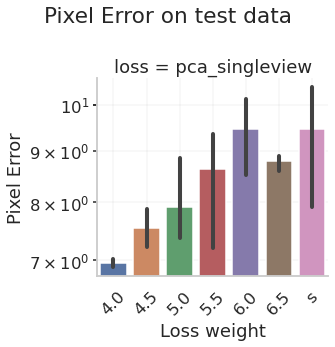

In [22]:
sns.set(context='talk', style='whitegrid', font_scale=1)

eval_mode = 'test'
y_label = get_y_label(to_compute)

# average over keypoints and frames
df_tmp_ = df_tmp[
    (df_tmp.eval_mode==eval_mode)
     & (df_tmp.loss_weight != str(3.0))
]
g = sns.catplot(
    x='loss_weight', y='value', 
    log=True,
#     order=['s'] + [str(w) for w in loss_weight_dict['pca_multiview']],
#     kind='strip', dodge=True,
    kind='bar',
    
    col='loss',
    col_wrap=1,
#     col_wrap=np.min([len(df_tmp_.loss.unique()), 3]), 
    data=df_tmp_,
#     col_order=['temporal', 'pca_singleview'],
    
#     col='bodypart',
#     row='loss',
#     col='bodypart',
#     col_wrap=4,
#     sharey=False,
#     data=df_tmp_, #[df_tmp_.loss=='pca_singleview'],
)
g.set_axis_labels('Loss weight', y_label)
g.set_xticklabels(rotation=45, ha='center')

for ax in g.axes.flatten():
    ax.tick_params(axis='y', which='both', direction='out', length=4, left=True)
    ax.grid(b=True, which='both', color='gray', linewidth=0.1)

# g.set(ylim=[5, 21])

g.fig.subplots_adjust(top=0.9)
if use_held_out_data:
    g.fig.suptitle('%s on held-out sessions' % y_label)
else:
    g.fig.suptitle('%s on %s data' % (y_label, eval_mode))
plt.tight_layout()
# base_dir = '/home/mattw/Dropbox/research-text/posters/2022_naisys_litpose'
# plt.savefig(os.path.join(base_dir, 'rick-mouse_held-out_rmse_eps=5.pdf'))
plt.show()